In [1]:
import os, sys
from datetime import datetime
from pathlib import Path
from types import SimpleNamespace
from typing import Callable, NamedTuple, Tuple
proj = Path.home() / "papercode/variational_sampling_methods"
sys.path.insert(0, str(proj))
# os.environ['PYTHONPATH'] = os.environ.get("PYTHONPATH","") + "~/papercode/variational_sampling_methods"
import hydra
import jax
import matplotlib
import distrax
import jax.numpy as jnp
import numpy as np
import time
import matplotlib.pyplot as plt
from learning.module.target_examples.funnel import Funnel
from learning.module.target_examples.gmm40 import GMM40
import functools
import chex
from omegaconf import OmegaConf
os.environ['HYDRA_FULL_ERROR'] = '1'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'



/home/sukchul/miniconda3/envs/mujoco/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/sukchul/miniconda3/envs/mujoco/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/sukchul/miniconda3/envs/mujoco/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.pr

Setup GMMVI

In [2]:
# from learning.module.gmmvi.component_adaptation import ComponentAdaptationState, setup_vips_component_adaptation
# from learning.module.gmmvi.configs import get_default_algorithm_config
# from learning.module.gmmvi.gmm_setup import GMMWrapper, GMMWrapperState, setup_full_cov_gmm, setup_gmm_wrapper
# from learning.module.gmmvi.ng_update import get_ng_update_fns
# from learning.module.gmmvi.sample_db import SampleDB, SampleDBState, setup_sampledb
# from learning.module.gmmvi.sample_selector import setup_fixed_sample_selector
# from learning.module.gmmvi.stepsize_update import WeightStepsizeAdaptationState, update_component_stepsize_adaptive
# from learning.module.gmmvi.weight_update import setup_weight_update_fn
# num_initial_components = 10
# prior_mean=0.
# prior_scale = 10.
# init_std = 10.
# dim=2
# config=get_default_algorithm_config('SAQTRUX')
# seed = 0
# initial_stepsize=1.0 # component stepsize and weight step size
# initial_l2_regularizer=1e-5
# use_diagonal_convs = False
# use_self_normalized_importance_weights = True
# temperature = 1.0
# # sample db config
# use_sample_database = False
# max_database_size = int(1e6)
# desire_samples_per_component = 100
# # sample selector config
# desired_samples_per_component = 100
# ratio_reused_samples_to_desired = 2.0
# #component stepsize config
# min_stepsize = 1e-4
# max_stepsize = 1.0
# stepsize_inc_factor = 1.1
# stepsize_dec_factor = 0.9
# #num component adaptation
# del_iters = 100
# add_iters = 30
# max_components = 1000
# thresholds_for_add_heuristic =  [5000.0, 1000.0, 500.0, 200.0, 100.0, 50.0]
# min_weight_for_del_heuristic = 1e-06
# num_database_samples = int(1e6)


# #Start Setting!
# rng = jax.random.PRNGKey(seed)
# gmm = setup_full_cov_gmm(dim)
# gmm_state = gmm.init_gmm_state(rng,
#                                 num_initial_components,
#                                 prior_mean,
#                                 prior_scale,
#                                 use_diagonal_convs,
#                                 init_std)
# model = setup_gmm_wrapper(gmm,
#                         initial_stepsize,
#                         initial_l2_regularizer,
#                         10000)
# model_state = model.init_gmm_wrapper_state(gmm_state)
# sample_db = setup_sampledb(dim,
#                            use_sample_database,
#                             max_database_size,
#                             use_diagonal_convs,
#                             desire_samples_per_component)
# sample_db_state = sample_db.init_sampleDB_state()
# # 'S' ; Stein Estimator +  'T' : Trust Rgeion Component Updater
# ng_update_fn, hass_grad_fn = get_ng_update_fns(model,
#                                         dim,
#                                         use_diagonal_convs,
#                                         use_self_normalized_importance_weights,
#                                         temperature,
#                                         initial_l2_regularizer,
#                                         )
# # 'A' vips component adaptation component increasing.
# component_adapter_state, component_adapter = setup_vips_component_adaptation(sample_db,
#                     model,
#                     dim,
#                     prior_mean,
#                     init_std ** 2,
#                     use_diagonal_convs,
#                     del_iters,
#                     add_iters,
#                     max_components,
#                     thresholds_for_add_heuristic,
#                     min_weight_for_del_heuristic,
#                     num_database_samples)
# # 'Q' Fixed Sample Selector we can't use other because target log prob is expensive
# sample_selector = setup_fixed_sample_selector(sample_db,
#                                                 model,
#                                                 desired_samples_per_component,
#                                                 ratio_reused_samples_to_desired)
# # 'R' Adaptive Component Stepsize update
# component_stepsize_fn = functools.partial(update_component_stepsize_adaptive, 
#                                             MIN_STEPSIZE=min_stepsize,               
#                                             MAX_STEPSIZE=max_stepsize,
#                                             STEPSIZE_INC_FACTOR=stepsize_inc_factor,
#                                             STEPSIZE_DEC_FACTOR=stepsize_dec_factor)
# # 'U' Direct Update
# weight_update_fn = setup_weight_update_fn(model,
#                                         temperature,
#                                         use_self_normalized_importance_weights)
# # 'X' Weight Stepsize Adaptation
# # Fxied so not implemented

# class GMMTrainingState(NamedTuple):
#     temperature: float
#     num_updates: chex.Array
#     model_state: GMMWrapperState
#     sample_db_state: SampleDBState
#     component_adaptation_state: ComponentAdaptationState
# class GMMNetwork(NamedTuple):
#     model : GMMWrapper
#     sample_db : SampleDB
#     ng_estimator : Callable
#     component_adapter : Callable
#     component_updater : Callable
#     sample_selector : Callable
#     component_stepsize_fn : Callable
#     weight_updater : Callable
# initial_train_state = GMMTrainingState(temperature=temperature,
#                                 num_updates=jnp.array([0]),
#                                 model_state=model_state,
#                                 sample_db_state=sample_db_state,
#                                 component_adaptation_state=component_adapter_state)
# gmm_network = GMMNetwork(model = model,
#            sample_db=sample_db,
#           ng_estimator=hass_grad_fn, 
#           component_adapter=component_adapter,
#           component_updater=ng_update_fn,
#           sample_selector=sample_selector,
#           component_stepsize_fn=component_stepsize_fn,
#           weight_updater=weight_update_fn)


In [3]:
from learning.module.gmmvi.network import create_gmm_network_and_state


dim=2
key= jax.random.PRNGKey(0)
batch_size=1024
initial_train_state, gmm_network = create_gmm_network_and_state(dim, batch_size, key)


In [4]:

from learning.module.gmmvi.network import GMMTrainingState

low = jnp.array([-10,-5])
high = jnp.array([5, 5])
def train_iter(train_state: GMMTrainingState, key: chex.Array, target_log_prob_fn):
    def get_target_grads(samples: chex.Array) -> Tuple[chex.Array, chex.Array]:
        # samples = jnp.where(jnp.logical_or(samples > high, samples < low) , \
        #                     jnp.clip(samples, low, high), samples)
        samples = jnp.clip(samples,low, high)
                            # jax.lax.stop_gradient(jnp.clip(samples, low, high)), samples)
        target, gradient = jax.vmap(jax.value_and_grad(target_log_prob_fn))(samples)
        return gradient, target
    key, subkey = jax.random.split(key)
    new_samples, mapping, num_reused_samples = gmm_network.sample_selector.select_samples(train_state.model_state,
                                        train_state.sample_db_state,
                                        subkey)

    # print("num samples", train_state.sample_db_state.samples.shape)
    # print('num_reused_samples', num_reused_samples)
    new_target_grads, new_target_lnpdfs = get_target_grads(new_samples)
    # new_target_grads, new_target_lnpdfs = get_target_grads(low+ (high-low) * jax.nn.sigmoid(new_samples))
    new_sample_db_state, samples, mapping, sample_dist_densities, target_lnpdfs, target_lnpdf_grads =\
        gmm_network.sample_selector.save_samples_and_select(train_state.model_state,
                                          train_state.sample_db_state,
                                            new_samples,
                                            new_target_lnpdfs,
                                            new_target_grads,
                                            mapping,
                                            num_reused_samples)
    # print("total sample for trainiing samples", samples.shape)
    new_component_stepsizes = gmm_network.component_stepsize_fn(train_state.model_state)
    new_model_state = gmm_network.model.update_stepsizes(train_state.model_state, new_component_stepsizes)
    expected_hessian_neg, expected_grad_neg = gmm_network.ng_estimator(new_model_state,
                                                            samples,
                                                            sample_dist_densities,
                                                            target_lnpdfs,
                                                            target_lnpdf_grads,
                                                            int(train_state.model_state.gmm_state.num_components))
    new_model_state = gmm_network.component_updater(new_model_state,
                                    expected_hessian_neg,
                                    expected_grad_neg,
                                    new_model_state.stepsizes)

    # new_weight_stepsize_adapter_state = weight_stepsize_adapter.update_stepsize(train_state.weight_stepsize_adapter_state, new_model_state)
    new_model_state = gmm_network.weight_updater(new_model_state, samples, sample_dist_densities, target_lnpdfs,
                                                    train_state.weight_stepsize)
    new_num_updates = train_state.num_updates + 1
    key, subkey = jax.random.split(key)
    new_model_state, new_component_adapter_state, new_sample_db_state = \
        gmm_network.component_adapter(train_state.component_adaptation_state,
                                                    new_sample_db_state,
                                                    new_model_state,
                                                    new_num_updates,
                                                    subkey)

    return GMMTrainingState(temperature=train_state.temperature,
                        model_state=new_model_state,
                        component_adaptation_state=new_component_adapter_state,
                        num_updates=new_num_updates,
                        sample_db_state=new_sample_db_state,
                        weight_stepsize=train_state.weight_stepsize)
def eval(seed: chex.Array, train_state: GMMTrainingState, target_log_prob_fn, n_eval_samples, target_samples=None):
    samples = gmm_network.model.sample(train_state.model_state.gmm_state, seed, n_eval_samples)[0]
    log_prob_model = jax.vmap(gmm_network.model.log_density, in_axes=(None, 0))(train_state.model_state.gmm_state, samples)
    log_prob_target = jax.vmap(target_log_prob_fn)(samples)
    log_ratio = log_prob_target - log_prob_model

    if target_samples is not None:
        fwd_log_prob_model = jax.vmap(gmm_network.model.log_density, in_axes=(None, 0))(train_state.model_state.gmm_state, target_samples)
        fwd_log_prob_target = jax.vmap(target_log_prob_fn)(target_samples)
        fwd_log_ratio = fwd_log_prob_target - fwd_log_prob_model
    else:
        fwd_log_ratio = None

    return samples, log_ratio, log_prob_target, fwd_log_ratio, n_eval_samples


In [5]:
from time import time

import wandb

from learning.module.target_examples.student_t_mixture import StudentTMixtureModel


target = StudentTMixtureModel(dim=dim, sample_bounds=[-30., 30.], num_components=40)
# target = GMM40(dim=dim, sample_bounds=[-30., 30.])
target = Funnel(dim=dim, sample_bounds=[-30, 30])
logger = {
    'KL/elbo': [],
    'KL/eubo': [],
    'logZ/delta_forward': [],
    'logZ/forward': [],
    'logZ/delta_reverse': [],
    'logZ/reverse': [],
    'ESS/forward': [],
    'ESS/reverse': [],
    'discrepancies/mmd': [],
    'discrepancies/sd': [],
    'other/target_log_prob': [],
    'other/EMC': [],
    "stats/step": [],
    "stats/wallclock": [],
    "stats/nfe": [],
}
def eval_fn(samples, log_ratio, target_log_prob, fwd_log_ratio, n_eval_samples):
    ln_z = jax.nn.logsumexp(log_ratio) - jnp.log(n_eval_samples)
    elbo = jnp.mean(log_ratio)

    if target.log_Z is not None:
        logger['logZ/delta_reverse'].append(jnp.abs(ln_z - target.log_Z))

    logger['logZ/reverse'].append(ln_z)
    logger['KL/elbo'].append(elbo)
    # logger['ESS/reverse'].append(compute_reverse_ess(log_ratio, n_eval_samples))
    logger['other/target_log_prob'].append(jnp.mean(target_log_prob))

    # if cfg.compute_forward_metrics and (target_samples is not None):
    #     eubo = jnp.mean(fwd_log_ratio)
    #     fwd_ln_z = - (jax.scipy.special.logsumexp(-fwd_log_ratio) - jnp.log(cfg.eval_samples))
    #     fwd_ess = jnp.exp(fwd_ln_z - (jax.scipy.special.logsumexp(fwd_log_ratio) - jnp.log(cfg.eval_samples)))

    #     if target.log_Z is not None:
    #         logger['logZ/delta_forward'].append(jnp.abs(fwd_ln_z - target.log_Z))
    #     logger['logZ/forward'].append(fwd_ln_z)
    #     logger['KL/eubo'].append(eubo)
    #     logger['ESS/forward'].append(fwd_ess)

    logger.update(target.visualise(samples=samples, show=True))

    # if cfg.compute_emc and cfg.target.has_entropy:
    #     logger['other/EMC'].append(target.entropy(samples))

    # for d in cfg.discrepancies:
    #     logger[f'discrepancies/{d}'].append(getattr(discrepancies, f'compute_{d}')(target_samples, samples,
    #                                                                                 cfg) if target_samples is not None else jnp.inf)
    # if cfg.moving_average.use_ma:
    #     logger.update(moving_averages(logger, window_size=cfg.moving_average.window_size))

    # if cfg.save_samples:
    #     save_samples(cfg, logger, samples)

    return logger



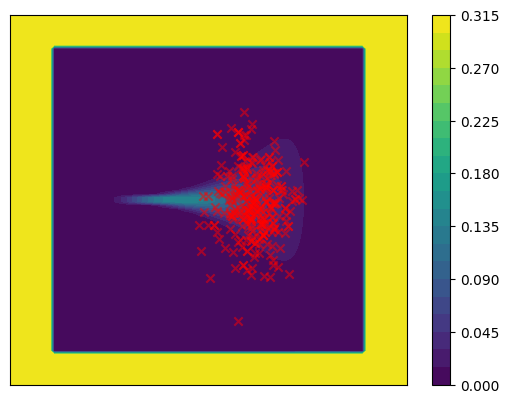

0/3000: The model now has 10 components 


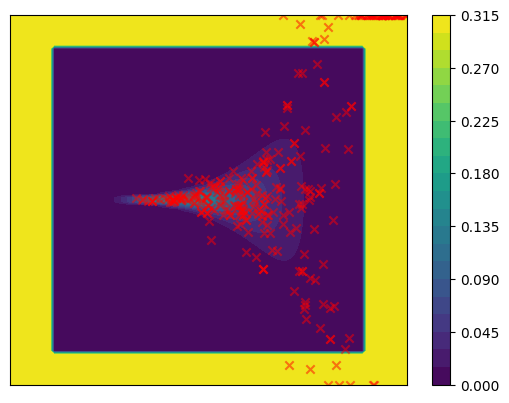

30/3000: The model now has 11 components 


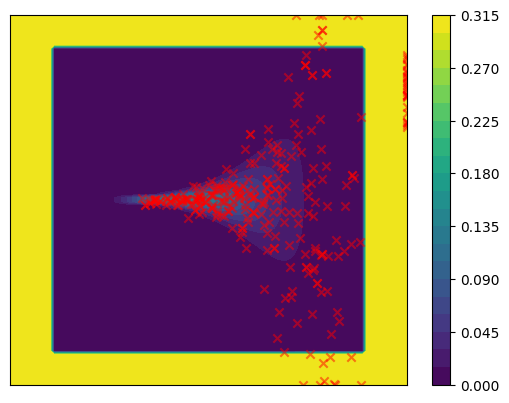

60/3000: The model now has 12 components 


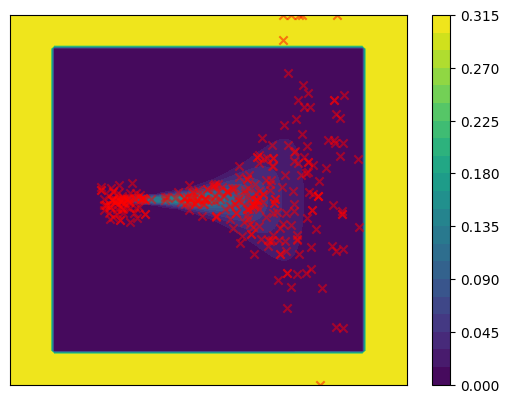

90/3000: The model now has 13 components 


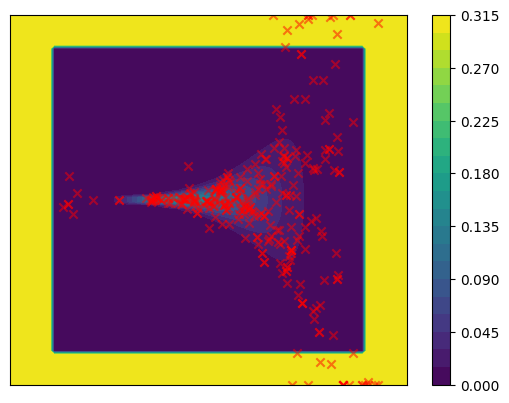

120/3000: The model now has 14 components 


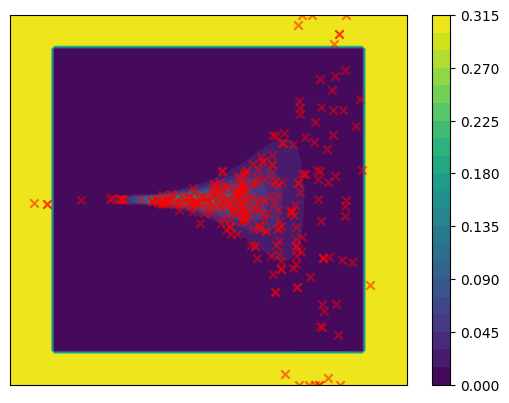

150/3000: The model now has 15 components 


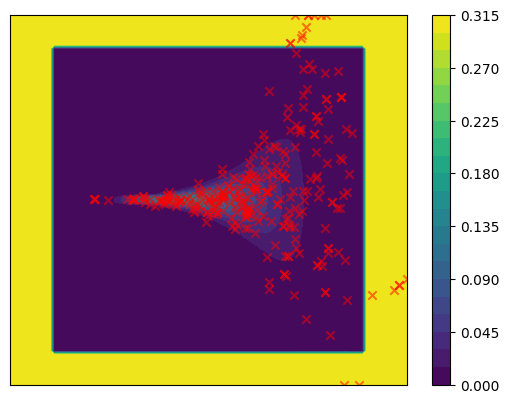

180/3000: The model now has 16 components 


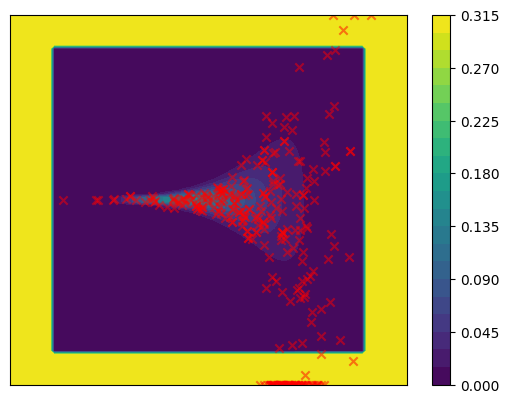

210/3000: The model now has 17 components 


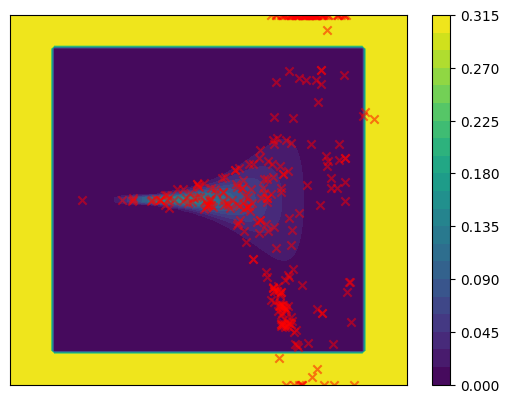

240/3000: The model now has 18 components 


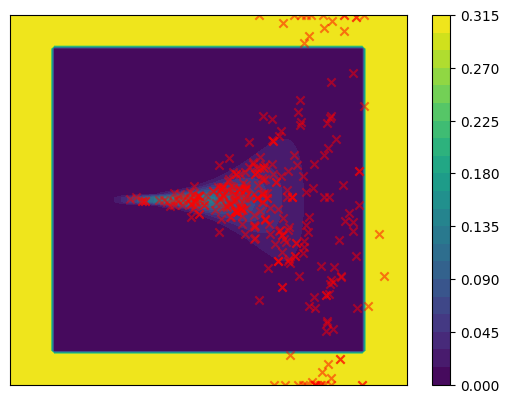

270/3000: The model now has 19 components 


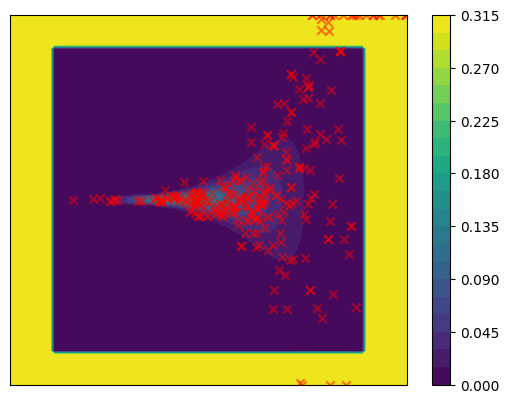

300/3000: The model now has 20 components 


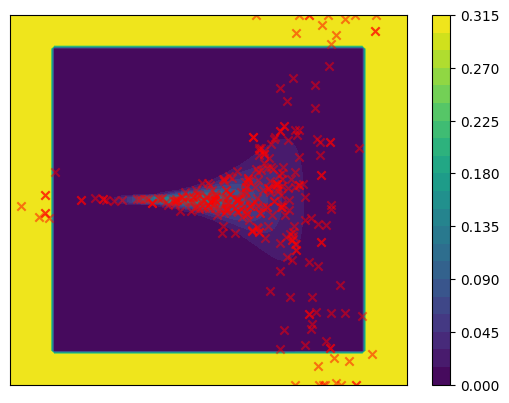

330/3000: The model now has 21 components 


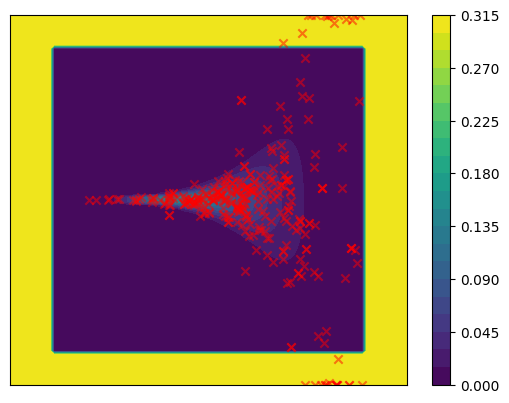

360/3000: The model now has 22 components 


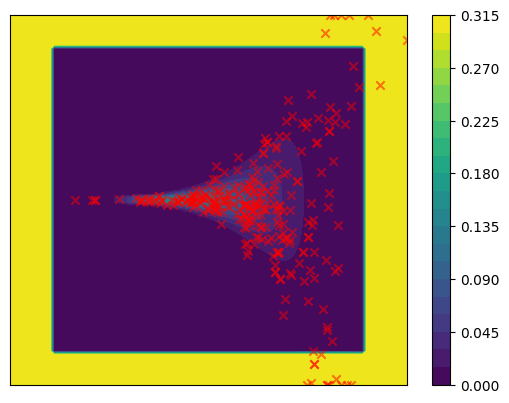

390/3000: The model now has 22 components 


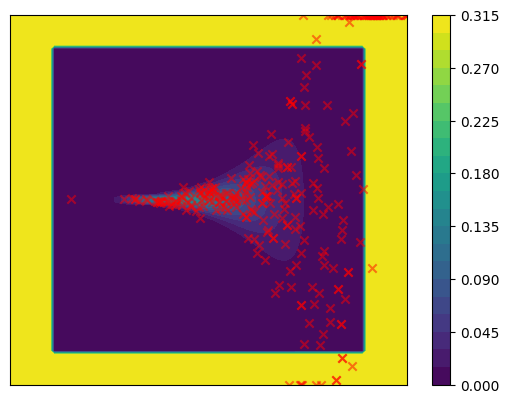

420/3000: The model now has 23 components 


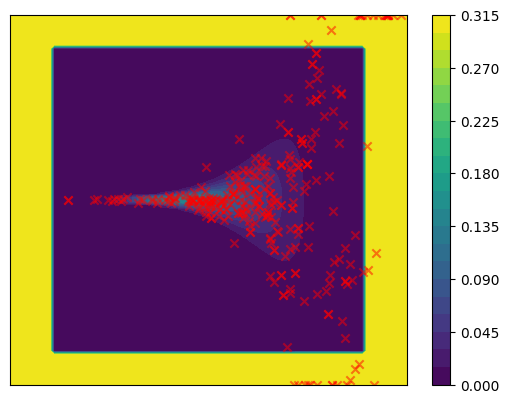

450/3000: The model now has 24 components 


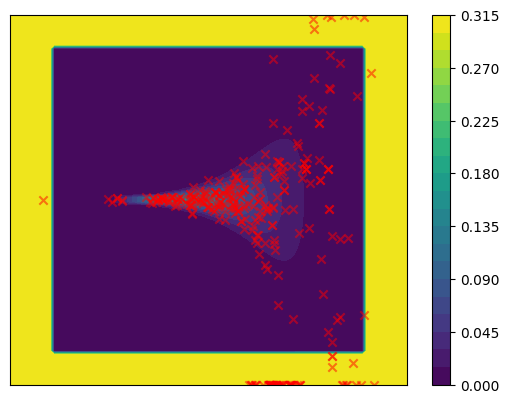

480/3000: The model now has 25 components 


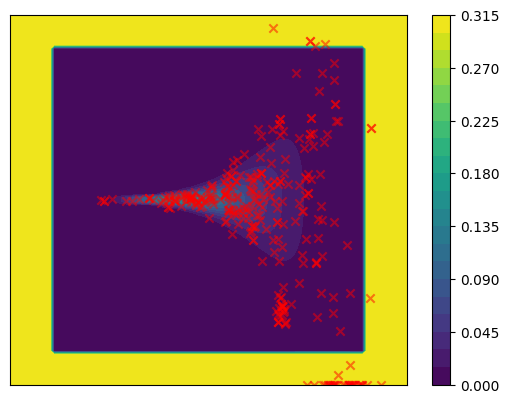

510/3000: The model now has 26 components 


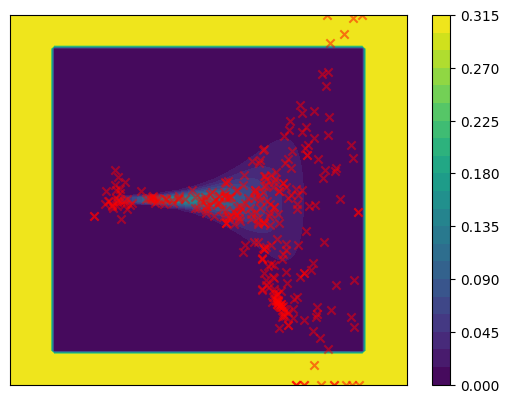

540/3000: The model now has 26 components 


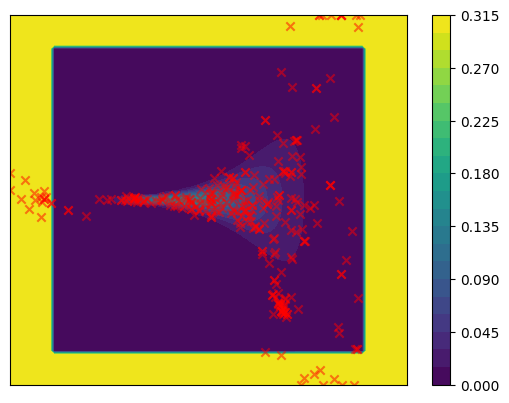

570/3000: The model now has 27 components 


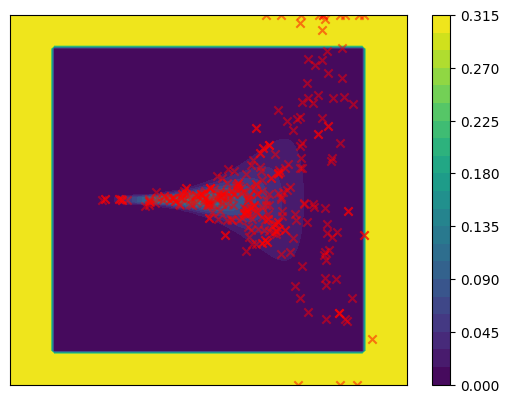

600/3000: The model now has 28 components 


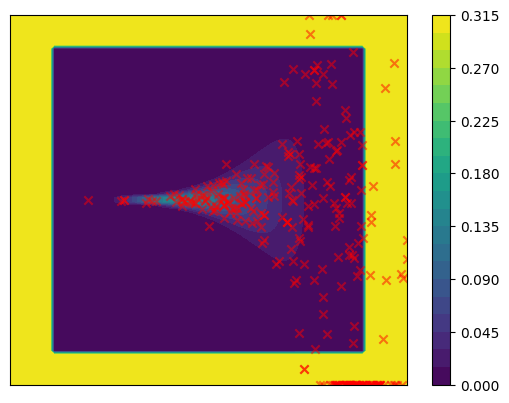

630/3000: The model now has 29 components 


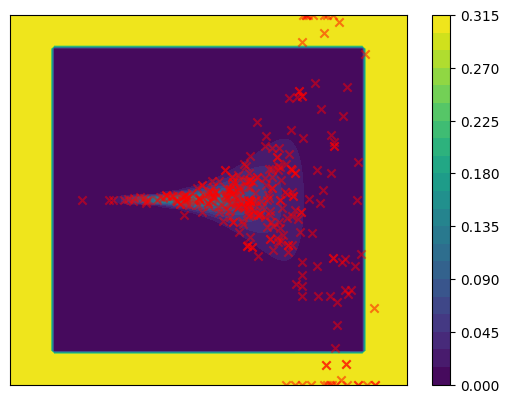

660/3000: The model now has 29 components 


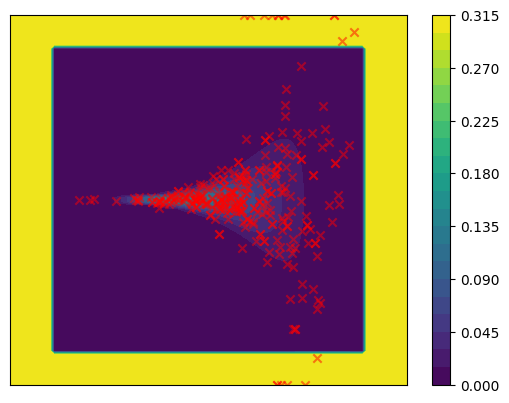

690/3000: The model now has 30 components 


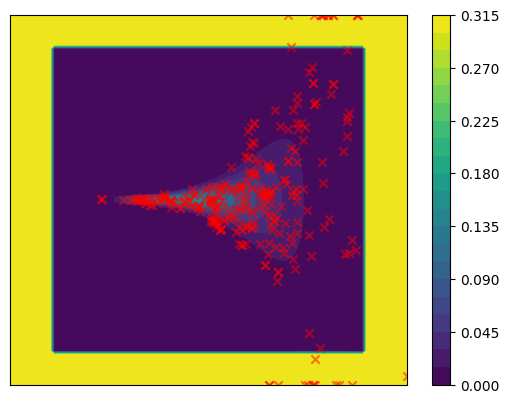

720/3000: The model now has 30 components 


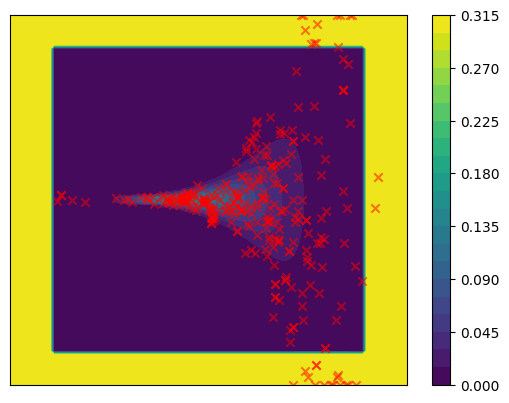

750/3000: The model now has 31 components 


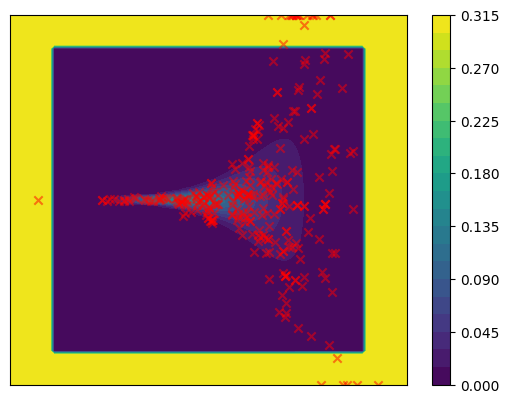

780/3000: The model now has 32 components 


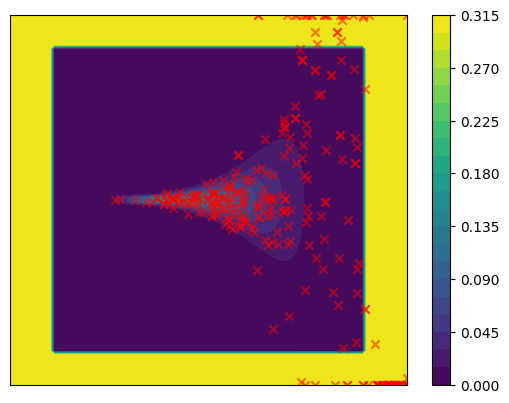

810/3000: The model now has 33 components 


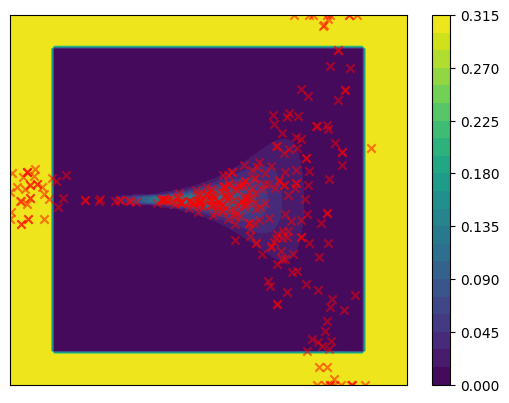

840/3000: The model now has 34 components 


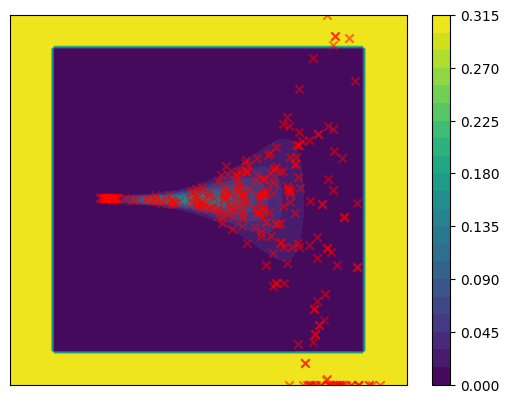

870/3000: The model now has 33 components 


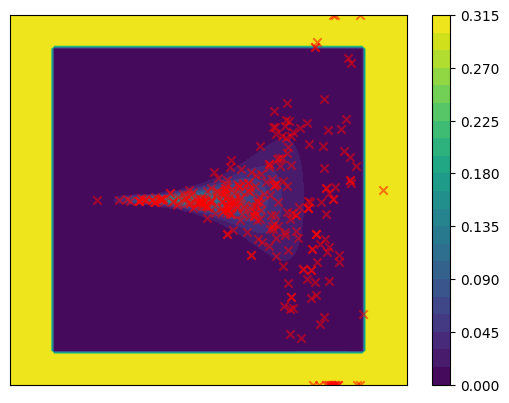

900/3000: The model now has 33 components 


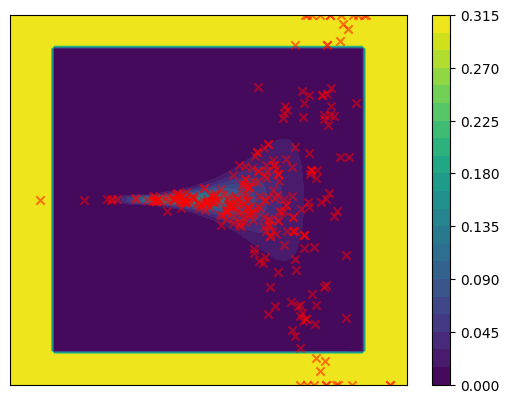

930/3000: The model now has 34 components 


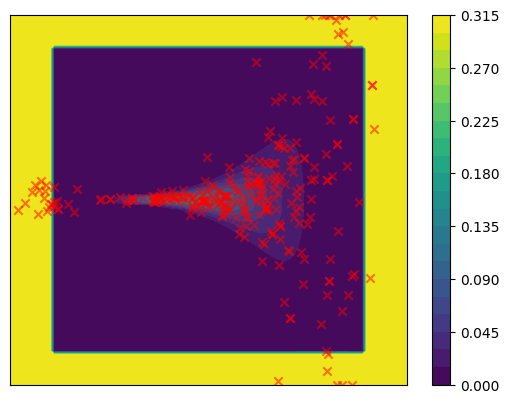

960/3000: The model now has 35 components 


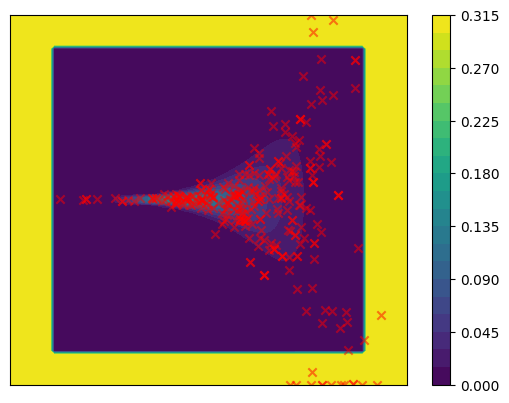

990/3000: The model now has 36 components 


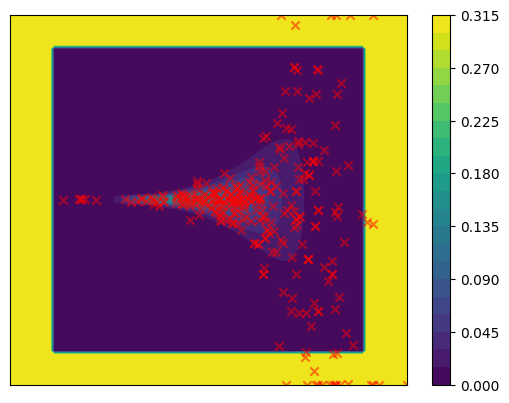

1020/3000: The model now has 37 components 


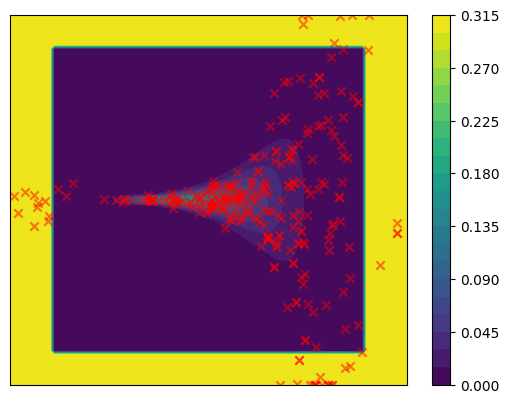

1050/3000: The model now has 38 components 


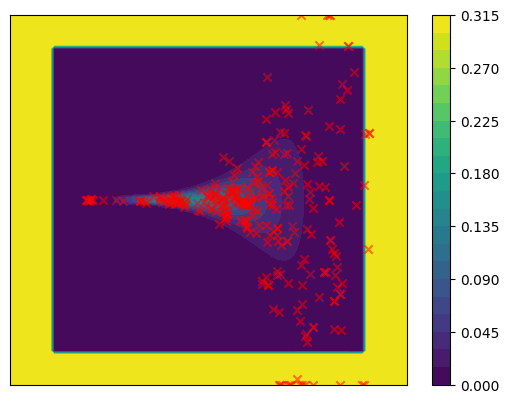

1080/3000: The model now has 39 components 


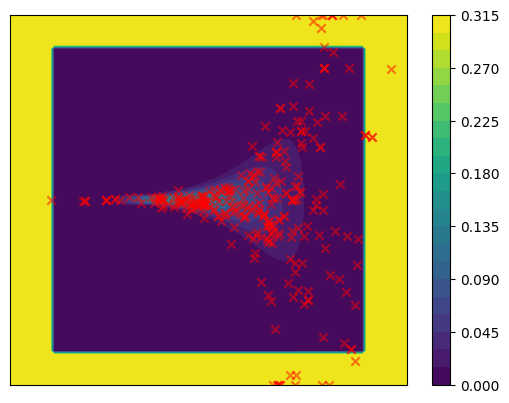

1110/3000: The model now has 40 components 


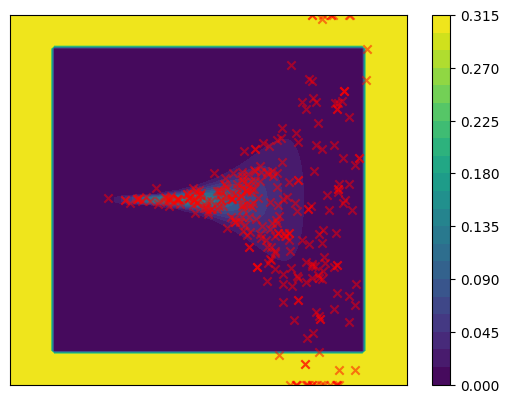

1140/3000: The model now has 41 components 


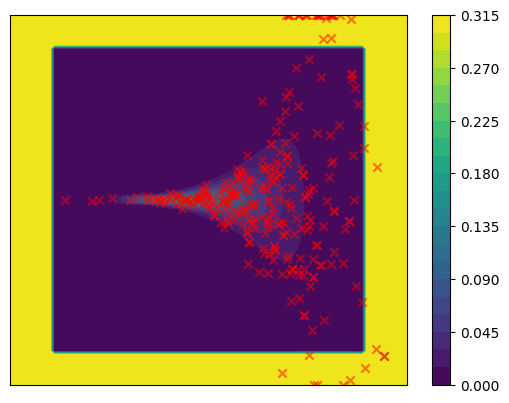

1170/3000: The model now has 41 components 


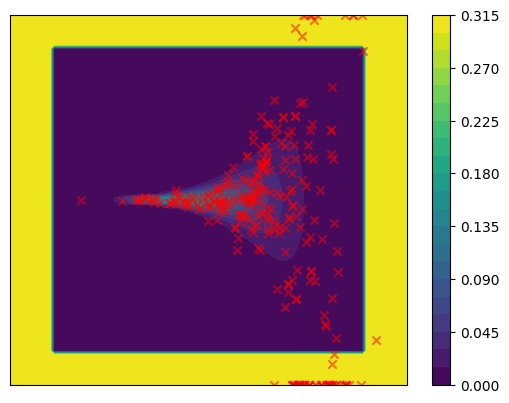

1200/3000: The model now has 42 components 


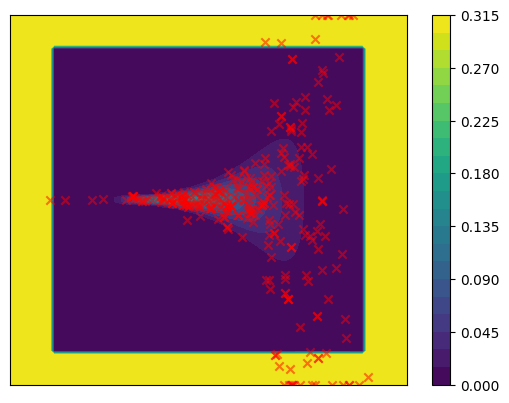

1230/3000: The model now has 43 components 


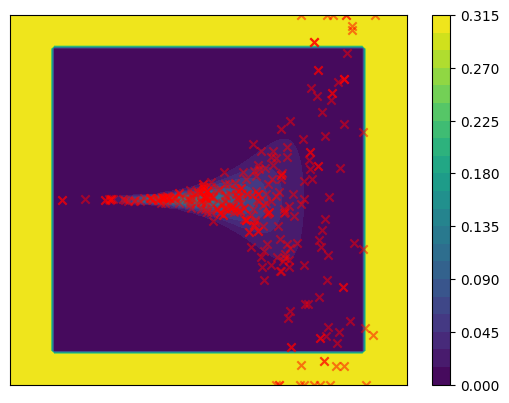

1260/3000: The model now has 44 components 


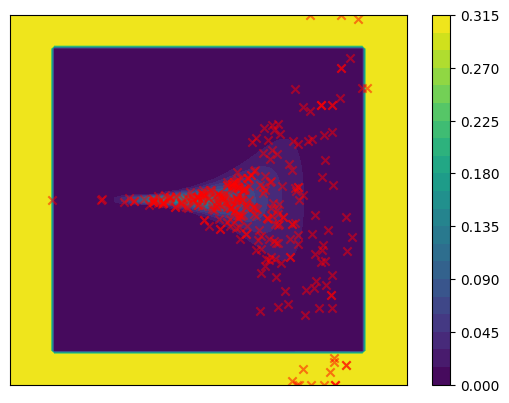

1290/3000: The model now has 44 components 


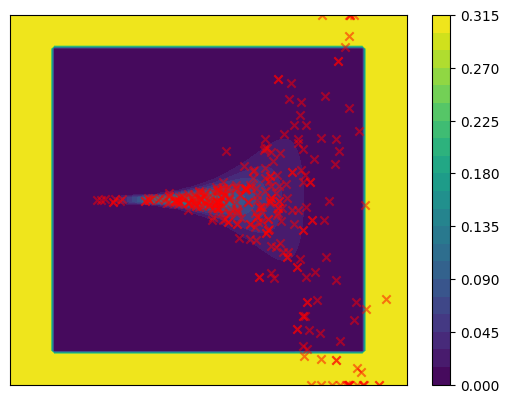

1320/3000: The model now has 45 components 


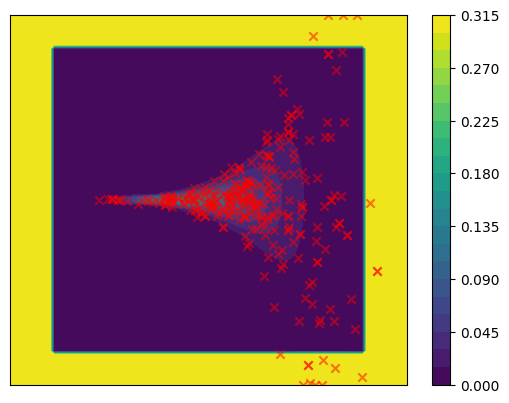

1350/3000: The model now has 46 components 


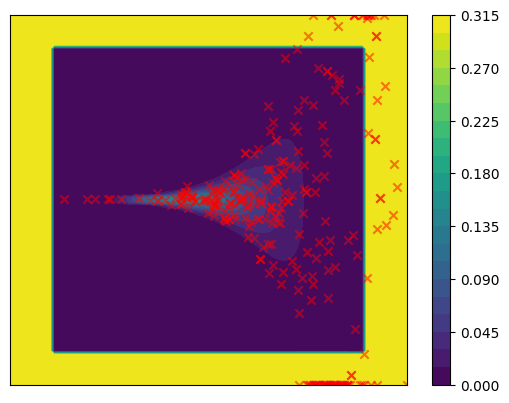

1380/3000: The model now has 46 components 


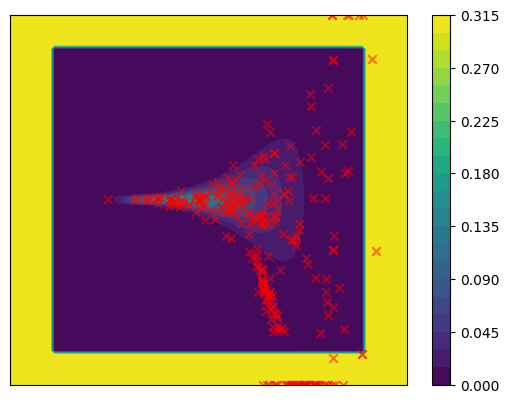

1410/3000: The model now has 46 components 


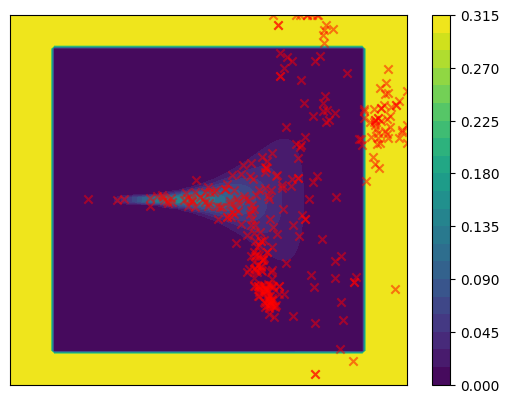

1440/3000: The model now has 47 components 


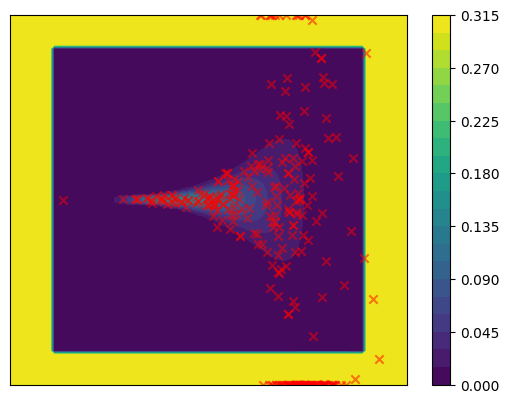

1470/3000: The model now has 48 components 


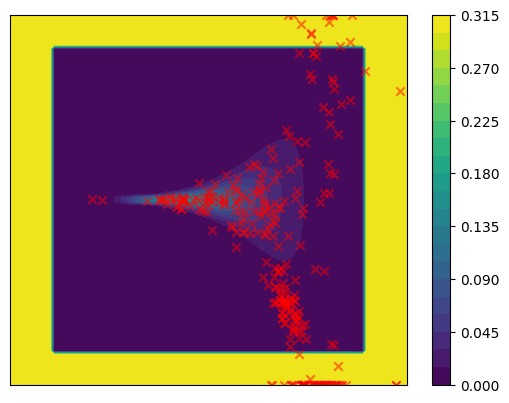

1500/3000: The model now has 49 components 


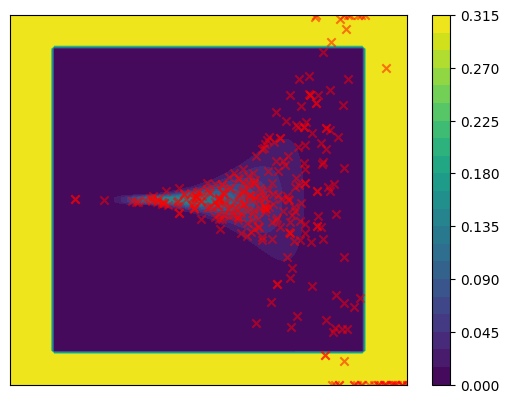

1530/3000: The model now has 50 components 


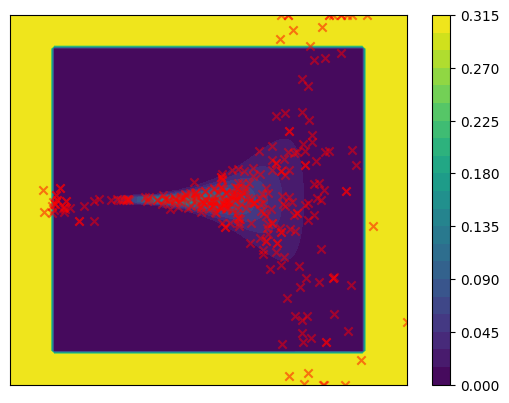

1560/3000: The model now has 50 components 


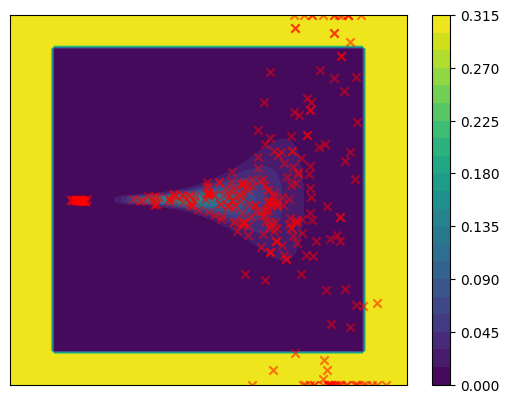

1590/3000: The model now has 50 components 


In [ ]:
iterations = 3000
seed=0
num_evals = 100
eval_freq = iterations//num_evals
n_eval_samples= 1000
target_samples = target.sample(jax.random.PRNGKey(0), (n_eval_samples,))
low = jnp.array([-10, -5])
high = jnp.array([5, 5])
# target_log_prob = jax.jit(lambda x : target.log_prob(jnp.clip(x, low,  high)))
target_log_prob_search = jax.jit(lambda x : target.log_prob(low+(high-low)*jax.nn.sigmoid(x)))
target_log_prob = jax.jit(lambda x : target.log_prob(x))
rng =jax.random.PRNGKey(seed)
key, rng = jax.random.split(rng)
timer = 0
state = initial_train_state
for step in range(0, iterations):
    iter_time = time()
    key, subkey = jax.random.split(key)
    state = train_iter(state, subkey, target_log_prob)
    timer += time() - iter_time
    if (step % eval_freq == 0) or (step == iterations - 1):
        key, subkey = jax.random.split(key)
        logger = eval_fn(*eval(subkey, state, target_log_prob, n_eval_samples, target_samples))
        logger["stats/step"].append(step)
        logger["stats/wallclock"].append(timer)
        logger['stats/num_samples'] = [state.sample_db_state.num_samples_written]
        logger['stats/num_components'] = [state.model_state.gmm_state.num_components]
        print(f"{step}/{iterations}: "
                f"The model now has {state.model_state.gmm_state.num_components} components ")

